In [1]:
import os
import cv2
import copy
import math
import time
import tqdm
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

### Step 1a) Fetch the dataset

In [8]:
root_dir1 = "../../datasets/ICard 2K Aligned/" #For Ubuntu
root_dir2 = "../../datasets/ICard_Extract/" #For Ubuntu

data_dir1 = "RegImgs/"
data_dir2 = "ValFNIR/"
data_dir3 = "ValFPIR/"

In [9]:
# c = 0

# for i in np.arange(10000, 13000):
#     f_name = str(i) + ".jpg"
#     img_name1 = os.path.join(root_dir1, data_dir1, f_name)
#     img_name2 = os.path.join(root_dir1, data_dir2, f_name)
    
#     if ((os.path.isfile(img_name1)) and (os.path.isfile(img_name2))):
#         img1 = cv2.imread(img_name1)
#         img2 = cv2.imread(img_name2)
        
#         cv2.imwrite(os.path.join(root_dir2, data_dir1, f_name), img1)
#         cv2.imwrite(os.path.join(root_dir2, data_dir2, f_name), img2)
        
#         c += 1

# print(c)

In [10]:
img_dir = os.listdir(root_dir2)
print('No. of examples :', len(img_dir))
#print(img_dir[:])

No. of examples : 3


In [11]:
tra = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(112),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.RandomCrop((h, w))
])

In [12]:
dataset = ImageFolder(root_dir2, transform=tra)

In [13]:
len(dataset)

6376

In [14]:
print(dataset.classes)

['RegImgs', 'ValFNIR', 'ValFPIR']


In [15]:
print(os.listdir(root_dir2))

['RegImgs', 'ValFNIR', 'ValFPIR']


In [16]:
image_size = [112, 112]

In [ ]:
img, label = dataset[2]
img_d = torch.permute(img, (1, 2, 0))
print(img_d.shape)
print(label)

plt.imshow(img_d)
plt.show()

In [ ]:
img, label = dataset[1986]
img_d = torch.permute(img, (1, 2, 0))
print(img_d.shape)
print(label)

plt.imshow(img_d)
plt.show()

In [ ]:
torch.max(img), torch.min(img)

In [17]:
nums = 1984

In [18]:
labels = torch.cat((torch.ones(nums), torch.zeros(nums)))
labels = labels.to(torch.long)
print(labels.shape)
print(labels)

torch.Size([3968])
tensor([1, 1, 1, 1, 1,  ..., 0, 0, 0, 0, 0])


In [19]:
data_list = torch.empty((nums*2, 2, 3, image_size[0], image_size[1]))
data_list.shape

torch.Size([3968, 2, 3, 112, 112])

In [20]:
for i in range(nums):
    img1, _ = dataset[i]
    img2, _ = dataset[i+nums]
    
    data_list[i][0] = img1
    data_list[i][1] = img2

In [21]:
for i in range(nums):
    img1, _ = dataset[i]
    img2, _ = dataset[i+nums*2]
    
    data_list[i+nums][0] = img1
    data_list[i+nums][1] = img2

In [22]:
data_list.shape

torch.Size([3968, 2, 3, 112, 112])

In [ ]:
img1 = data_list[0][0]
img2 = data_list[0][1]
img1 = torch.permute(img1, (1, 2, 0))
img2 = torch.permute(img2, (1, 2, 0))

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

In [ ]:
torch.max(img), torch.min(img)

In [ ]:
img1 = data_list[1945][0]
img2 = data_list[1945][1]
img1 = torch.permute(img1, (1, 2, 0))
img2 = torch.permute(img2, (1, 2, 0))

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

### Step 2a) Model Architecture - Network

In [23]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [24]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [25]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [26]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [27]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [28]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                        nn.ReLU(inplace=True),
                        nn.AdaptiveAvgPool2d(1),
                        #nn.AvgPool2d(kernel_size=2, stride=2),
                        Flatten(), #2048-d embeddings
                        #nn.Linear(n_channels[n_groups]*2, 512) #512-d embeddings
                       ]
        
        #self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        embed = self.features(x)
        return embed #self.fc(embed)

In [29]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50():
    return MyResNet(4, N_50, k=2)

def ResNet101():
    return MyResNet(4, N_101, k=2)

def ResNet152():
    return MyResNet(4, N_152, k=2)

In [30]:
loaded_model = ResNet50()
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

### Step 2b) Loading the pre-trained Model

In [31]:
# loaded_model.load_state_dict(
#     torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_26_Feb_features_89acc.pth"))
# loaded_model.load_state_dict(
#     torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_27_Feb_features_91acc.pth"))
loaded_model.load_state_dict(
    torch.load("../Checkpoints/ResNet50_Softmax/ResNet50_Softmax_28_Feb_features_97acc.pth"))

<All keys matched successfully>

In [32]:
for param in loaded_model.parameters():
    param.requires_grad = False

In [33]:
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [34]:
summary(loaded_model, input_size = (3, 50, 50), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
         MaxPool2d-2           [-1, 64, 13, 13]               0
       BatchNorm2d-3           [-1, 64, 13, 13]             128
            Conv2d-4          [-1, 256, 13, 13]          16,384
            Conv2d-5           [-1, 64, 13, 13]           4,096
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]          16,384
         ResBlock-12          [-1, 256, 13, 13]               0
      BatchNorm2d-13          [-1, 256, 13, 13]             512
           Conv2d-14           [-1, 64,

### Step 2b) Loading the pre-trained Model - Option2

In [35]:
# class CosFace(nn.Module):
#     def __init__(self, in_features=2048, out_features=5749, s=64.0, m=0.35):
#         super(CosFace, self).__init__()
#         self.in_features = in_features
#         self.out_features = out_features
#         self.s = s
#         self.m = m
#         self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
#         nn.init.normal_(self.kernel, std=0.01)

#     def forward(self, logits, labels):
#         logits = F.normalize(logits, p=2.0, dim=1) #l2_norm(logits, axis=1)
#         kernel_norm = F.normalize(self.kernel, p=2.0, dim=0) #l2_norm(self.kernel, axis=0)
#         cos_theta = torch.mm(logits, kernel_norm)
#         cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
#         index = torch.where(labels != -1)[0]
#         m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
#         m_hot.scatter_(1, labels[index, None], self.m).to(device)
#         cos_theta[index] -= m_hot
#         ret = cos_theta * self.s
#         return ret

In [36]:
# new_logits = CosFace()

In [ ]:
# #checkpoint = torch.load("../Checkpoints/ResNet50_CosFacev2/2048-d/ResNet50_CosFace_28_Feb_5.pt")
# checkpoint = torch.load("../Checkpoints/ResNet50_CosFacev2/512-d/ResNet50_CosFace_15_Mar_30.pt")

# loaded_model.load_state_dict(checkpoint['model_state_dict'])
# #opt1 = checkpoint['model_optimizer_state_dict']
# #opt2 = checkpoint['fc_optimizer_state_dict']
# #opt2['state'][0]['momentum_buffer']
# #n.kernel.shape

# train_acc = checkpoint['train_acc']
# val_acc = checkpoint['val_acc']
# print(train_acc, val_acc)

# # val_acc = checkpoint['acc']
# # print(val_acc)

In [ ]:
# for param in loaded_model.parameters():
#     param.requires_grad = False

In [ ]:
# to_device(loaded_model, device)

### Step 3) Testing the model

In [37]:
def compute_embedding(model, xb, sim_metric):
    with torch.no_grad():
        features = model(xb) #F.normalize(model(xb))
        score = sim_metric(features[0], features[1])
    
    return score

In [38]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)

In [39]:
def ver_accuracy(scores, img_targets, thres_arr):
    targets_tensor = img_targets
    #print(targets_tensor.shape)
    
    acc_list = []
    
    for thres in thres_arr:
        outputs = scores >= thres
        #print(outputs.shape, outputs)
        outputs = outputs.long()
        #print(outputs.shape, outputs)
        matches = outputs == targets_tensor
        #print(matches.shape, matches)
        matches = matches.long()
        success = torch.count_nonzero(matches)
        acc = success/matches.shape[0] * 100
        acc_list.append(np.round(acc.item(), 2))
        
        print("Thres: ", thres, "| Veri acc.: ", np.round(acc.item(), 2))
    
    return targets_tensor, acc_list

In [40]:
def compute_scores(img_pairs, img_targets):
    
    scores = []
    len = img_targets.shape[0]
    
    for idx in tqdm.tqdm(np.arange(0, len)):
        pair = img_pairs[idx]
        actual = img_targets[idx]
        
        #convert pair to pytorch tensor, normalize
        img1 = pair[0]
        img2 = pair[1]
  
        #convert into a batch
        new_pair = torch.stack((img1, img2), 0).to(device)
        
        score = compute_embedding(loaded_model, new_pair, similarity)
        #print(actual, score.item())
        
        scores.append(score.item())
    
    scores = torch.FloatTensor(scores)
    #print(scores.shape, scores)
    
    return scores

In [41]:
computed_scores = compute_scores(data_list, labels)
print(computed_scores.shape)

100%|███████████████████████████████████████| 3968/3968 [00:40<00:00, 98.25it/s]

torch.Size([3968])


In [42]:
print(computed_scores)
print(torch.min(computed_scores), torch.max(computed_scores))

tensor([0.4102, 0.2876, 0.3664, 0.2188, 0.2557,  ..., 0.2232, 0.2307, 0.1805,
        0.1608, 0.2011])
tensor(0.0609) tensor(1.)


In [43]:
thresholds = [0.1, 0.2, 0.27, 0.3, 0.4, 0.5]
#thresholds = [0.099]
#thresholds = [0.9, 0.5, 0.099, 0.1026817]

targets_tensor, acc = ver_accuracy(computed_scores, labels, thresholds)

Thres:  0.1 | Veri acc.:  50.33
Thres:  0.2 | Veri acc.:  66.96
Thres:  0.27 | Veri acc.:  82.54
Thres:  0.3 | Veri acc.:  79.49
Thres:  0.4 | Veri acc.:  58.27
Thres:  0.5 | Veri acc.:  50.98


In [44]:
def plot_ROC(y_true, y_prob):

    fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=True)
    sum_sensitivity_specificity = tpr + (1-fpr)
    best_threshold_id = np.argmax(sum_sensitivity_specificity)
    best_threshold = thresholds[best_threshold_id]
    best_fpr = fpr[best_threshold_id]
    best_tpr = tpr[best_threshold_id]
    y_pred = y_prob > best_threshold

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print('Best threshold: %.3f' %best_threshold)
    printmd('**Accuracy: %.2f**' %(acc*100))
    print('AUC: %.4f ' %auc)
    
    printmd('**Confusion Matrix:**')
    print(cm)
    
    printmd('**Classification Report:**')
    print(classification_report(y_true, y_pred))

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    
    curve1 = ax.plot(fpr, tpr)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr, best_tpr, marker='o', color='black')
    ax.text(best_fpr, best_tpr, s = '(%.3f,%.3f)' %(best_fpr, best_tpr))
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.4f'%auc)

    plt.savefig('ROC_LFW', dpi = 500)
    plt.show()
    
    return fpr, tpr, thresholds

Best threshold: 0.270


**Accuracy: 82.56**

AUC: 0.8256 


**Confusion Matrix:**

[[1746  238]
 [ 454 1530]]


**Classification Report:**

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1984
           1       0.87      0.77      0.82      1984

    accuracy                           0.83      3968
   macro avg       0.83      0.83      0.83      3968
weighted avg       0.83      0.83      0.83      3968



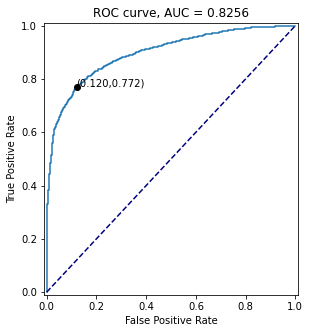

In [45]:
fpr, tpr, th = plot_ROC(labels, computed_scores)

In [46]:
def plot_rates(fpr, tpr, th):
    
    plt.plot(th, fpr)
    plt.plot(th, 1-tpr)
    #plt.plot(th, tpr)
    
    plt.legend(['FPIR', 'FNIR', 'TPIR'])
    plt.xlabel('Thresholds')
    plt.ylabel('FPIR, FNIR')
    plt.show()

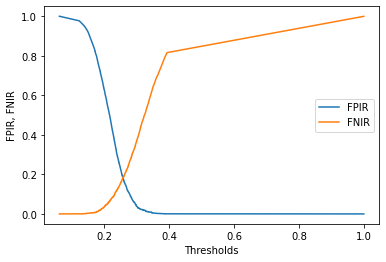

In [47]:
plot_rates(fpr[1:], tpr[1:], th[1:])